In [1]:
!python -m spacy download en_core_web_md -qq

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kiahm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               2000 non-null   object
 1   review             2000 non-null   object
 2   rating             2000 non-null   int64 
 3   isEdited           2000 non-null   bool  
 4   userName           2000 non-null   object
 5   title              2000 non-null   object
 6   developerResponse  15 non-null     object
dtypes: bool(1), int64(1), object(5)
memory usage: 95.8+ KB
None
           rating
count  2000.00000
mean      3.88950
std       1.44891
min       1.00000
25%       3.00000
50%       5.00000
75%       5.00000
max       5.00000
date                 object
review               object
rating                int64
isEdited               bool
userName             object
title                object
developerResponse    object
dtype: object


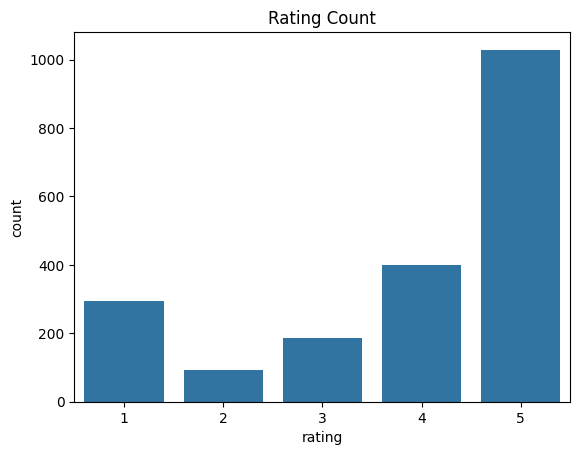

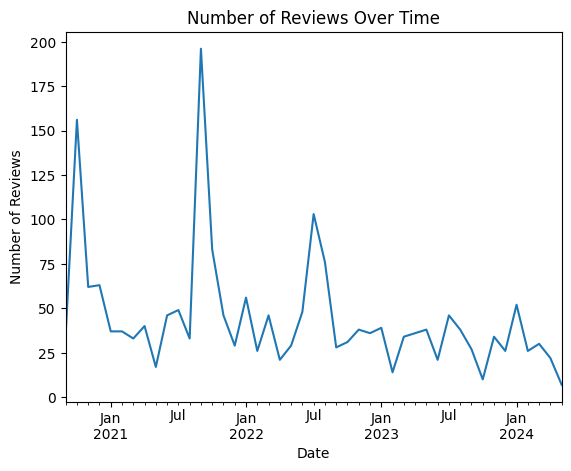

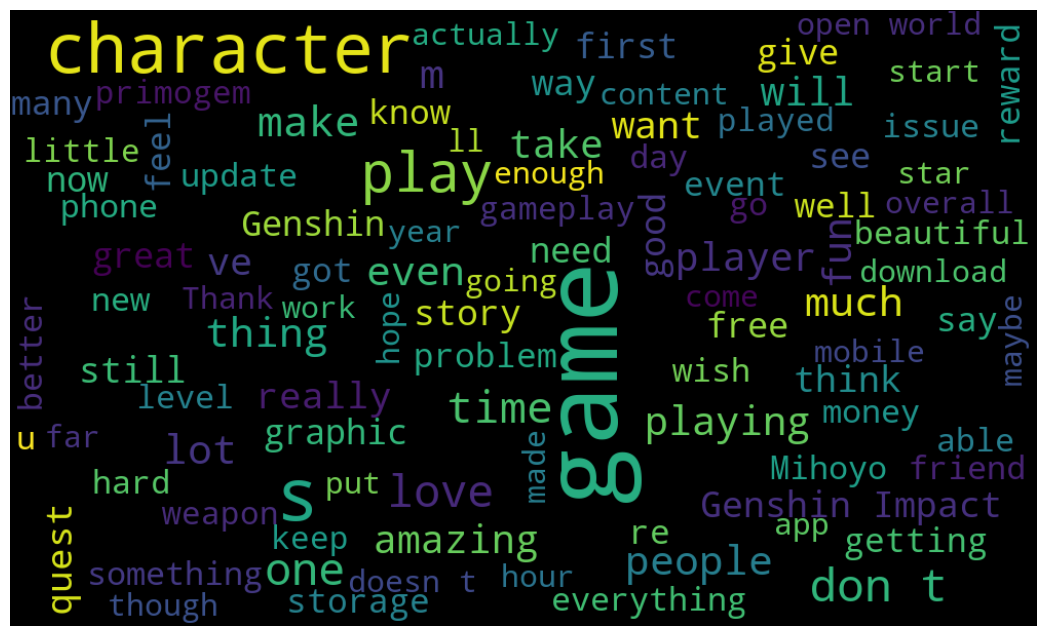

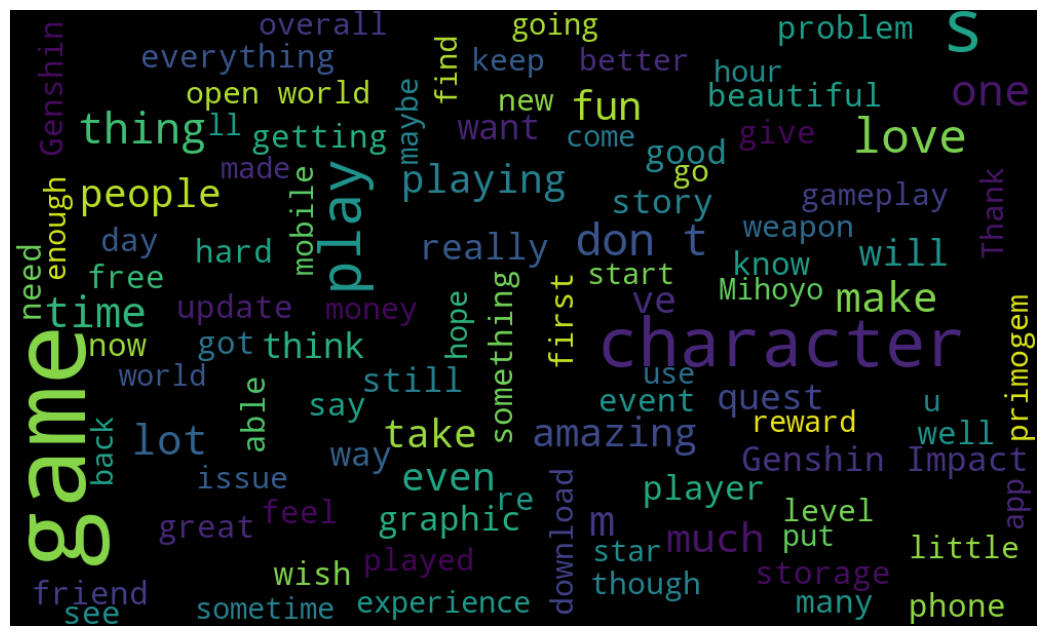

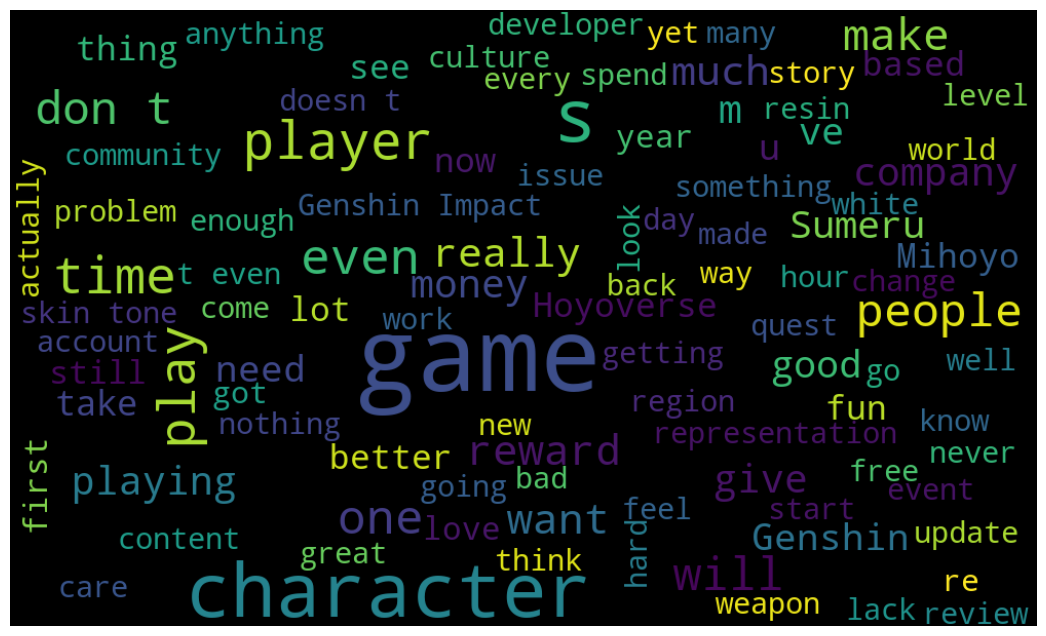

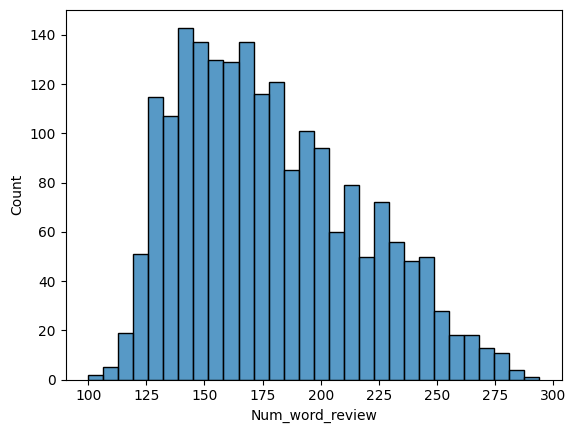

C:\Users\kiahm\AppData\Local\Temp\ipykernel_19920\3260963195.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="Common_words", data=temp, palette=sns.color_palette("Set2"))
C:\Users\kiahm\AppData\Local\Temp\ipykernel_19920\3260963195.py:4: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x="count", y="Common_words", data=temp, palette=sns.color_palette("Set2"))


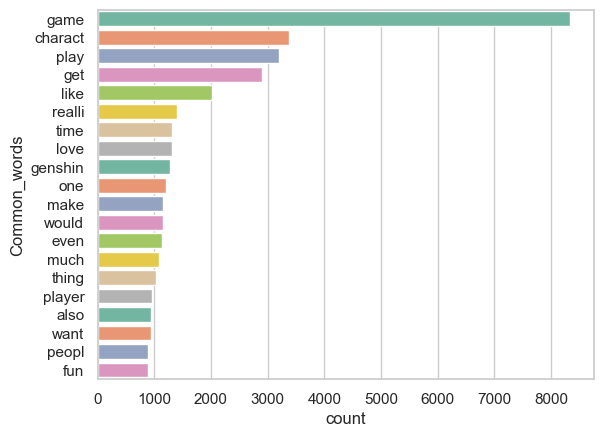

In [2]:
%run Analysis.ipynb

In [3]:
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

In [4]:
# Creating pipeline for tokenizing and modelling
# Our spaCy model:
nlp = en_core_web_md.load()
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for review in nlp.pipe(USreview_copy['review']):
   proj_tok = [token.lemma_.lower() for token in review if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

In [5]:
USreview_copy['tokens'] = tokens
USreview_copy['tokens']

0       [anyth, action, relat, game, quest, whatev, ge...
1       [play, genshin, year, fan, get, realli, enjoy,...
2       [game, good, game, download, great, open, word...
3       [peopl, judg, game, video, screenshot, price, ...
4       [game, insan, play, total, day, accord, hoyola...
                              ...                        
1995    [hello, like, someth, quest, place, inazuma, e...
1996    [let, start, game, amaz, new, player, enjoy, g...
1997    [great, game, enjoy, play, game, love, use, ga...
1998    [invest, time, game, truli, believ, money, gra...
1999    [realli, genshin, impact, favorit, game, love,...
Name: tokens, Length: 2000, dtype: object

In [6]:
dictionary = Dictionary(USreview_copy['tokens'])

print(dictionary.token2id)

{'achiev': 0, 'action': 1, 'ad': 2, 'add': 3, 'anim': 4, 'anyth': 5, 'area': 6, 'bit': 7, 'boss': 8, 'break': 9, 'bunch': 10, 'caus': 11, 'charact': 12, 'chest': 13, 'collect': 14, 'differ': 15, 'earthl': 16, 'etc': 17, 'everywher': 18, 'explan': 19, 'explor': 20, 'fat': 21, 'feel': 22, 'find': 23, 'fire': 24, 'game': 25, 'genshin': 26, 'glitchi': 27, 'good': 28, 'graphic': 29, 'handl': 30, 'help': 31, 'hope': 32, 'idk': 33, 'item': 34, 'job': 35, 'kill': 36, 'kind': 37, 'level': 38, 'like': 39, 'list': 40, 'littl': 41, 'long': 42, 'love': 43, 'mani': 44, 'map': 45, 'monster': 46, 'obes': 47, 'ok': 48, 'opinion': 49, 'plenti': 50, 'power': 51, 'quest': 52, 'rare': 53, 'recommend': 54, 'relat': 55, 'say': 56, 'sometim': 57, 'sorri': 58, 'star': 59, 'teleport': 60, 'thank': 61, 'time': 62, 'updat': 63, 'upgrad': 64, 'use': 65, 'want': 66, 'water': 67, 'waypoint': 68, 'weapon': 69, 'whatev': 70, 'wish': 71, 'write': 72, 'zelda': 73, 'abyss': 74, 'amaz': 75, 'archon': 76, 'aspect': 77, 'aw

In [7]:
# filter out low-frequency and high-frequency tokens, also limit the vocabulary to a max of 1000 w
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

corpus = [dictionary.doc2bow(rev) for rev in USreview_copy['tokens']]

In [8]:
# Model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

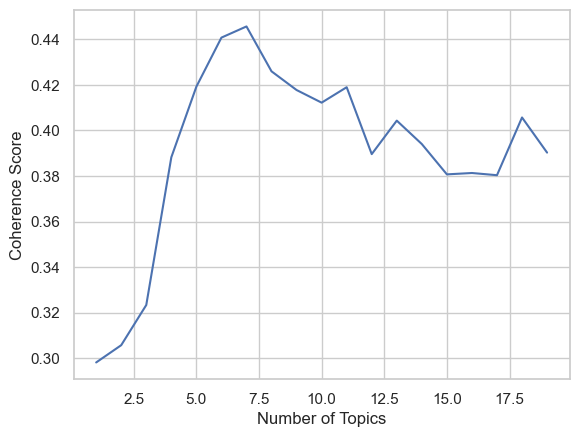

In [9]:
# Optimal no. of topics? Calculate coherence score using C_v
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = USreview_copy['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()
plt.show()

We see that maximum coherence score occurs at around 7 topics.

In [10]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=7, workers = 4, passes=100)

In [11]:
lda_model.print_topics(-1)

[(0,
  '0.028*"star" + 0.026*"wish" + 0.019*"primogem" + 0.017*"weapon" + 0.017*"good" + 0.017*"resin" + 0.016*"system" + 0.015*"want" + 0.015*"time" + 0.014*"banner"'),
 (1,
  '0.028*"storag" + 0.021*"mobil" + 0.019*"download" + 0.018*"phone" + 0.013*"realli" + 0.013*"problem" + 0.013*"delet" + 0.013*"app" + 0.012*"time" + 0.012*"tri"'),
 (2,
  '0.049*"skin" + 0.034*"dark" + 0.032*"sumeru" + 0.024*"peopl" + 0.024*"region" + 0.024*"base" + 0.022*"cultur" + 0.017*"white" + 0.017*"hoyover" + 0.016*"tone"'),
 (3,
  '0.020*"time" + 0.020*"spend" + 0.019*"stori" + 0.018*"free" + 0.016*"fun" + 0.014*"money" + 0.013*"good" + 0.013*"lot" + 0.012*"world" + 0.012*"gacha"'),
 (4,
  '0.031*"love" + 0.028*"realli" + 0.019*"like" + 0.018*"genshin" + 0.016*"thing" + 0.015*"good" + 0.015*"think" + 0.013*"want" + 0.013*"know" + 0.012*"peopl"'),
 (5,
  '0.038*"player" + 0.032*"reward" + 0.019*"genshin" + 0.018*"mihoyo" + 0.018*"anniversari" + 0.015*"compani" + 0.014*"year" + 0.014*"money" + 0.013*"commu

In [12]:
print('Review: ', genshinUS_reviews['review'][0])
print('Topic: ', lda_model[corpus][0])
# According to the LDA model, the above review belongs to topic 5 (35.6%) and 6 (63.6%)

Review:  If your into anything action related or into games with quests or whatever, Genshin Is what I recommend. This game you have a whole obese map and you can explore everywhere and get teleport waypoints to always go to different areas and it's useful for quests so you can just teleport. The game is kind of like Zelda in my opinion. You can collect weapons and explore like I said and kill all kinds of monsters or bosses. You can also collect and level up characters by finding chests and making wishes. You can even upgrade your weapons and they thankfully don't break at all. The characters even have useful powers like fire or water, etc and are useful to use. And there's always updates to the game. And the graphics and animations are amazing. I wrote 4 stars though cause sometimes the game can be a little glitchy (rarely but still) and I feel there's a bit too much to it. I be having 15+ quests almost 24/7 and there's so many others they want me to find and add to the list of the f

In [13]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

The above chart represents our five topics as circles. Topics closer to each other are more related.

In [14]:
USreview_copy['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(USreview_copy['review']))]

In [15]:
USreview_copy.topic.value_counts()

topic
0    777
1    625
3    210
2    186
4    145
5     45
6     12
Name: count, dtype: int64